In [ ]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd
from dateutil import tz
from astral import Astral
from Utilities import *
from ModelTest import loadTestSets

In [5]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Load Feather data

In [6]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_raw = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times

def get_dawn_dusk(ts):
    a = Astral()
    a.solar_depression = "civil"
    city = a["Sacramento"]
    
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

## No controls

In [7]:
n_LF = 6
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
max_it = 100

#ti, tf = 29060, 29160#30000#15040, 15240
ti, tf = 16700, 16850
Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

#Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


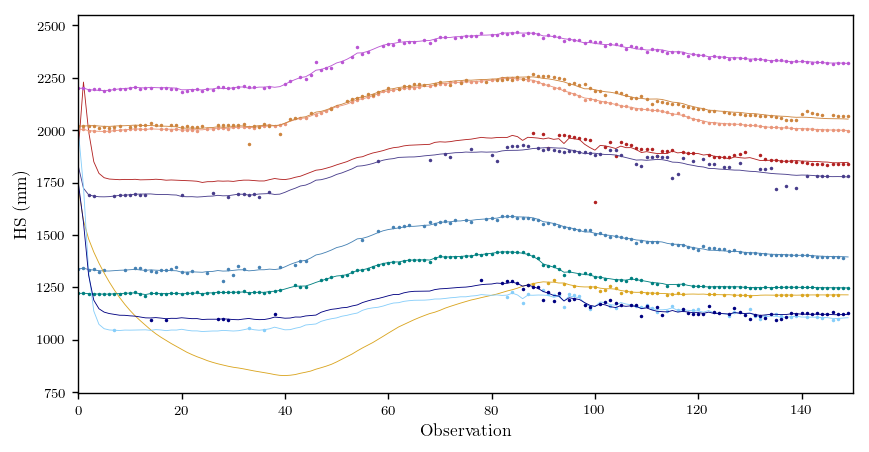

In [8]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

## Using controls to de-flutter summer data
The second with index 6 exhibits very clear flutter that should be reasonably simple to handle. Let's try dealing with it first. Need to process $P_{\rm solar}$ and $T_{\rm air}$ time series first:

### Setup
HS, $P_{\rm solar}$ as observations

In [203]:
sensors = [6]

ti, tf = 29060, 30000 #30500 29178
Y = np.vstack((y_sd_raw[ti:tf, sensors].T, y_rad_raw[ti:tf].reshape(-1, 1).T))

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state. Convention: s_t = 1 if day, 0 if night
# ss = []

# for t in range(tf-ti):
#     # Get dawn and dusk times
#     dawn, dusk = get_dawn_dusk(times[ti+t:ti+t+1])
#     # Append 1 if it's daytime, 0 if not
#     ss.append(1 if dawn[0] < times[ti+t] < dusk[0] else 0)
    
# ss = np.array(ss, dtype=int)

# s_list = [0, 1]

ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

### Run algorithm

In [204]:
n_LF = 2
max_it = 50

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)

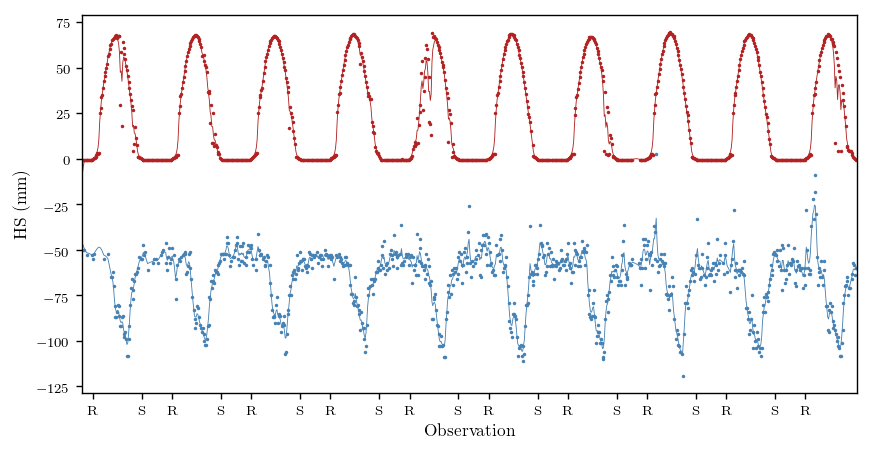

In [206]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)*2), colors):
    plt.plot(times[ti:tf], Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(times[ti:tf], Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(times[ti], times[tf])
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

# Tick x axis at dawn and dusk each day
dawns, dusks = get_dawn_dusk(times[ti:tf:96])
dawn_dusk_ticks = np.array(zip(dawns, dusks)).flatten()
plt.xticks(dawn_dusk_ticks[:-1], ["R", "S"] * (len(dawn_dusk_ticks) / 2))

In [15]:
print "As:\n", As
print "\nBs:\n", Bs
print "\nCs:\n", Cs
print "\nDs:\n", Ds
print "\nRs:\n", Rs

As:
[[[ 0.59511693]]

 [[ 0.98706667]]]

Bs:
[[[ -1.50503086e-02   4.86275343e+01]]

 [[  2.00378384e-02  -2.33221445e-02]]]

Cs:
[[[-0.10911978]]

 [[ 2.7154626 ]]]

Ds:
[[[-58.6678845 ]]

 [[ 62.15333765]]]

Rs:
[[[ 3.57577581]]

 [[ 0.        ]]]


## Regress cumulative sum of ${\rm HS}$ on $P_{\rm solar}$
Need to fill gaps before this can be done effectively

In [74]:
hs_hat = Y_hat[0, :]
rad_hat = Y_hat[1, :]

In [120]:
day_hs = [[]]
day_rad = [[]]

for t in range(tf-ti):
    # Get dawn and dusk times
    dawn, dusk = get_dawn_dusk(times[ti+t:ti+t+1])
    
    # If it's day, append to day's radiation or HS
    if dawn[0] < times[ti+t] < dusk[0]:
        day_hs[-1].append(hs_hat[t])
        day_rad[-1].append(rad_hat[t])
    # If it's about to become night, add a new day's list
    if times[ti+t] < dusk[0] < times[ti+t+1]:
        day_hs.append([])
        day_rad.append([])

KeyboardInterrupt: 

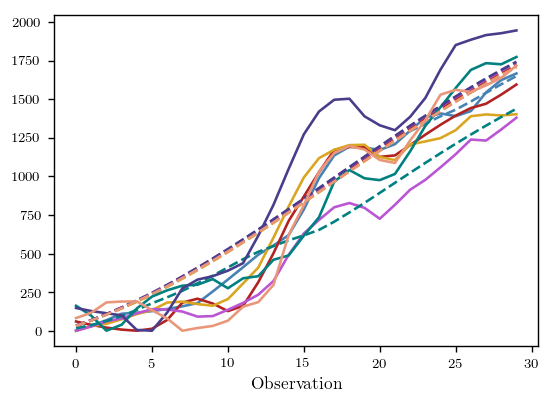

In [218]:
for rad, hs, c in zip(day_rad, day_hs, colors):
    plt.plot(np.array(np.cumsum(np.power(rad[10:40], 1.0))), '--', color=c)
    plt.plot(-35*(np.array(hs[10:40]) - np.max(np.array(hs[10:40]))), '-', color=c)
    #plt.plot((np.array(hs) - np.max(np.array(hs))) / np.array(np.cumsum(np.power(rad, 1.0))), '.')

plt.xlabel("Observation")
    
#plt.ylim(-0.02, 0.02)

## Checking PCA-only result

(0, 200)

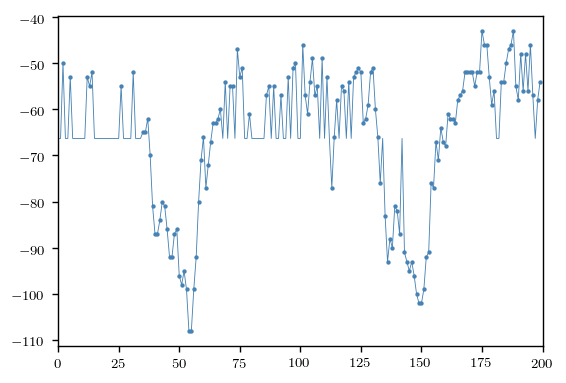

In [10]:
Y_mean = np.nanmean(Y, axis=1).reshape(-1, 1)
C, X_PCA, Y_imp = pca_est_MD(Y - Y_mean, n_LF, max_it)

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_imp[s, :] + Y_mean[s], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=3.0, color=c)
    
plt.xlim(0, tf-ti)

In [ ]:
#ti, tf = 27005, 27500
#ti, tf = 27015, 27055 # ~ night
#ti, tf = 27065, 27105 # ~ day
ti, tf = 15005, 15205 # ~ 2 full days

plt.plot(y_sd_raw[ti:tf, :])